# Reading your own data

## 1. Epoched data with MNE (recommended)

Starting from epoched data is the recommended method as the internal functions in hmp to epoch data (see next section) might not be suitable for your specific experiment. Note that this method assumes that your epoch contain both the starting (stimulus) and ending (response) event of your trials!

An HMP model works on a single trial basis. A trial is defined as the onset of a stimulus and the time at which the response was provided (reaction time, RT). Now, to restrict the analyzed data to this duration we need to pass the information of the trial RT along the time-series we are using (e.g. EEG/MEG channels). The easiest way of doing this is to rely on triggers that were co-registered with the data and that signal useful events such as which stimulus was presented and which answer was given. In MNE this is done either by using events or by using so-called metadata (see MNE's [tutorial](https://mne.tools/dev/auto_tutorials/epochs/30_epochs_metadata.htmlhttps://mne.tools/dev/auto_tutorials/epochs/30_epochs_metadata.html)). In section 1.1 we explain how to prepare the data if you have metadata available, section 1.2 explains what to do if metadata is not integrated in your epoched dataset.

**NOTE** if you want to run these examples you need to first download the data:

In [1]:
import os
import requests
from mne.io import read_info
import matplotlib.pyplot as plt

# Declaring path where the EEG data will be stored
epoch_data_path = os.path.join('sample_data', 'eeg')
os.makedirs(epoch_data_path, exist_ok=True)

# URLs of the first 5 participants in the SAT experiment, navigate the osf folder and adapt those if you want to do this tutorial on other data (e.g. P3, N2pc)
file_urls = [
    "https://osf.io/download/67cffa85f67af67e7a92f0a6/",
    "https://osf.io/download/67cffa85f67af67e7a92f0a8/",
    "https://osf.io/download/67cffa85f67af67e7a92f0aa/",
    "https://osf.io/download/67cffa85f67af67e7a92f0ac/",
    "https://osf.io/download/67cffa85f67af67e7a92f0ae/",
]

# Download and save each file if not already in folder
for i, url in enumerate(file_urls, start=1):
    file_path = os.path.join(epoch_data_path, f'participant{i}_epo.fif')
    if not os.path.exists(file_path):
        response = requests.get(url)
        with open(file_path, 'wb') as f:
            f.write(response.content)

### 1.1 Example with metadata

For this section we will rely on data  we will use the data from application 2 of this [this](https://link.springer.com/article/10.1007/s42113-021-00105-2) paper. For the purpose of this tutorial we will only use the first 5 participants of the data (see the [HMP]((https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00400/125469)) paper for the method and [https://osf.io/29tgr/](https://osf.io/29tgr/) for the whole (preprocessed) data).

__Important note__ Given that we are using the RT as a cutting point selecting appropriate trimming is very important. For example a typical perceptual decision making is unlikely to be made with RT shorter than 200 ms nor RT longer than 2 seconds. Therefore the next function uses ```lower_limit_RT=0.2``` and ```upper_limit_RT=2``` to apply these criteria.

### 1.1.1 Reading the data

In [2]:
import hmp
sfreq = 100 #at what sampling rate we want the data, downsampling to 100Hz is computationally less intensive for hmp instances

# Recovering individual files and participant names
subj_files = [os.path.join(epoch_data_path, f) for f in os.listdir(epoch_data_path) if f.endswith('.fif')]  # Create a list of files with full paths
subj_names = [os.path.splitext(f)[0] for f in os.listdir(epoch_data_path) if f.endswith('.fif')]  # Extract subject names based on file names

# Then we read the data (see more in Tutorial 1)
epoch_data = hmp.io.read_mne_data(subj_files, sfreq=sfreq, data_format='epochs',
                            lower_limit_rt=0.2, upper_limit_rt=2, 
                            rt_col = 'RT', scale = 1000, #In this case the rts are contained in the dataframe column "RT" and is in milliseconds, thus we adapt 
                            verbose=False, subj_name=subj_names)#Turning verbose off for the documentation but it is recommended to leave it on as some output from MNE might be useful

Processing participant sample_data/eeg/participant3_epo.fif's epochs eeg
177 trials were retained for participant sample_data/eeg/participant3_epo.fif
Processing participant sample_data/eeg/participant4_epo.fif's epochs eeg
159 trials were retained for participant sample_data/eeg/participant4_epo.fif
Processing participant sample_data/eeg/participant5_epo.fif's epochs eeg
183 trials were retained for participant sample_data/eeg/participant5_epo.fif
Processing participant sample_data/eeg/participant1_epo.fif's epochs eeg
187 trials were retained for participant sample_data/eeg/participant1_epo.fif
Processing participant sample_data/eeg/participant2_epo.fif's epochs eeg
193 trials were retained for participant sample_data/eeg/participant2_epo.fif


```hmp.io.read_mne_data``` automatically reads the epoched data and converts it to an xarray dataset. Any metadata that has been saved along zith the epoched data is also kept (hence avoid too large metadata and only keep the important metadata).

In [3]:
print(epoch_data)

<xarray.Dataset> Size: 47MB
Dimensions:      (participant: 5, epoch: 200, channel: 30, sample: 194)
Coordinates:
  * epoch        (epoch) int64 2kB 0 1 2 3 4 5 6 ... 193 194 195 196 197 198 199
  * channel      (channel) <U3 360B 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * sample       (sample) int64 2kB 0 1 2 3 4 5 6 ... 188 189 190 191 192 193
    stim         (participant, epoch) float64 8kB 1.0 nan 1.0 ... 2.0 1.0 2.0
    resp         (participant, epoch) object 8kB 'resp_left' ... 'resp_right'
    RT           (participant, epoch) float64 8kB 907.0 nan ... 468.0 350.0
    cue          (participant, epoch) object 8kB 'AC' nan 'AC' ... 'SP' 'AC'
    movement     (participant, epoch) object 8kB 'stim_left' ... 'stim_right'
    trigger      (participant, epoch) object 8kB 'AC/stim_left/resp_left' ......
  * participant  (participant) <U16 320B 'participant3_epo' ... 'participant2...
Data variables:
    data         (participant, epoch, channel, sample) float64 47MB -7.935 .....
A

### 1.1.2 Working with sensor location

To be able to graphically represent how each transition event translates in the scalp topology we need to pass the info of the channel locations on the head.

Reading /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/sample_data/eeg/participant3_epo.fif ...
    Found the data of interest:
        t =    -250.00 ...    2998.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
186 matching events found
No baseline correction applied
0 projection items activated


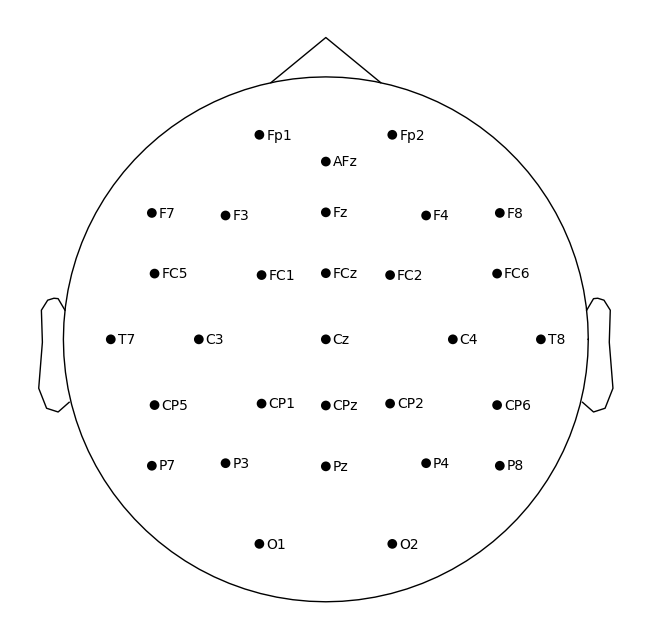

In [4]:
# The following code is just to illustrate channel positions
import mne

epoch = mne.read_epochs(subj_files[0])
epoch.plot_sensors(show_names=True);



When we have access to the mne data format and if the channel positions have been stored during the preprocessing step, the position of the electrode is contained in the ```info``` object from the file we read using ```mne```. Hence we can first read any of the participants data (assuming the electrode position is the same) and 
directly pass that object to the ```plot_topo_timecourse``` . 
We first fit an HMP model (see tutorial 2) to illustrate the use of channel position

In [5]:
# See the two next tutorials for more details on how to fit an HMP model and how to visualize the results.
preprocessed = hmp.preprocessing.Standard(epoch_data, n_comp=6)
pattern = hmp.patterns.HalfSine.create_expected(sfreq=epoch_data.sfreq)
trial_data = hmp.trialdata.TrialData.from_preprocessed(preprocessed=preprocessed, pattern=pattern.template)
model = hmp.models.EventModel(pattern, n_events=4)
_, estimates = model.fit_transform(trial_data)

/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/preprocessing.py:165: UserWarning: Data will be modified inplace, re-read the data or use copy=True if multiplecalls to this function
  warn(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/preprocessing.py:347: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Estimating 4 events model with 1 starting point(s)


We then have the illustration of channel activities for each event: 

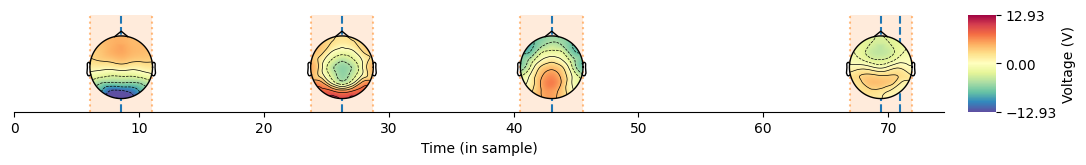

In [6]:
from mne.io import read_info
info = read_info(subj_files[0], verbose=False)
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info)

### 1.2 Example without metadata

If you haven't stored the metadata along with the epoched data you can always provide a list of RTs and condition to parse the data, However you need to be sure that the order of the trials from which you take the info is the same as the EEG data. Here an example with the same data as previously:

For example we can extract the actual metadata from the epoched object. This is dataframe as you could have while reading behavioral data co-registered with the EEG.

In [7]:
epoch = mne.read_epochs(subj_files[0])
epoch.metadata

Reading /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/sample_data/eeg/participant3_epo.fif ...
    Found the data of interest:
        t =    -250.00 ...    2998.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
186 matching events found
No baseline correction applied
0 projection items activated


,stim,resp,RT,cue,movement,trigger
0,1,resp_left,907,AC,stim_left,AC/stim_left/resp_left
2,1,resp_right,1095,AC,stim_left,AC/stim_left/resp_right
3,2,resp_left,1370,AC,stim_right,AC/stim_right/resp_left
5,2,resp_right,907,AC,stim_right,AC/stim_right/resp_right
7,2,resp_right,891,AC,stim_right,AC/stim_right/resp_right
...,...,...,...,...,...,...
195,1,resp_right,1763,AC,stim_left,AC/stim_left/resp_right
196,1,resp_left,676,AC,stim_left,AC/stim_left/resp_left
197,2,resp_left,0,SP,stim_right,SP/stim_right/resp_left
198,2,resp_right,649,AC,stim_right,AC/stim_right/resp_right


In this case you can read the MNE epoched data, add the metadata for each participant, and save the data then re-read using the previous section

In [8]:
import mne
import pandas as pd

# Example: assume 'behavior' is a DataFrame with columns ['RT', 'condition', ...] for each participant
# Here, we just extract the metadata from the EEG data as a placeholder
epochs_list = []
for eeg_file in subj_files:
    epochs = mne.read_epochs(eeg_file, preload=True)
    # Extract metadata or load your own behavioral data here
    # For demonstration, we use the metadata from the epochs object if available
    if epochs.metadata is not None:
        metadata = epochs.metadata.copy()
    else:
        # If no metadata, create a dummy DataFrame (replace with your actual behavioral data)
        n_trials = len(epochs)
        metadata = pd.DataFrame({'RT': [1.0]*n_trials, 'condition': ['dummy']*n_trials})
    epochs.metadata = metadata
    epochs.save(eeg_file, overwrite=True)

Reading /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/sample_data/eeg/participant3_epo.fif ...
    Found the data of interest:
        t =    -250.00 ...    2998.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
186 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 6 columns
Overwriting existing file.
Overwriting existing file.
Reading /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/sample_data/eeg/participant4_epo.fif ...
    Found the data of interest:
        t =    -250.00 ...    2998.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
159 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 6 columns
Overwriting existing file.
Overwriting existing file.
Reading /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/sample_data/eeg/participant5_epo.fif

## 2. Reading raw data

The following is useful if you:
- Do not have the behavioral data to use RTs and associated conditions
- Haven't epoched the data or just want to take a quick look at HMP models with raw data lying around

__Nota bene__: the data is assumed to be preprocessed and only works with .bdf and .fif (also BIDS, see section 4)

In this case we will simulate EEG data with a structure close to actual recordings

In [9]:
from hmp import simulations
import numpy as np
from scipy.stats import gamma

cpus = 2 # For multiprocessing, usually a good idea to use multiple CPUs as long as you have enough RAM

n_trials = 100 #Number of trials to simulate
sfreq = 500 #Sampling rate of the simulated data

##### Here we define the sources of the brain activity (event) for each trial
n_events = 4 #How many events to simulate
frequency = 10. #Frequency of the event defining its duration, half-sine of 10Hz = 50ms
amplitude = .2e-7 #Amplitude of the event in nAm, defining signal to noise ratio
shape = 2 #shape of the gamma distribution, with the defined means below it dictates the onset time probabilities
means = np.array([60, 150, 200, 100, 80])/shape #Mean duration of the between event times in ms
#Which source to activate for each event (see atlas when calling simulations.available_sources())
names = ['inferiortemporal-lh','caudalanteriorcingulate-rh','bankssts-lh','superiorparietal-lh','superiorparietal-lh']

sources = []
for source in zip(names, means): #One source = one frequency, one amplitude and a given by-trial variability distribution
    sources.append([source[0], frequency, amplitude, gamma(shape, scale=source[1])])

# Function used to generate the data
file = simulations.simulate(sources, n_trials, cpus, 'dataset', overwrite=False, sfreq=sfreq, seed=0)
#load electrode position, specific to the simulations
info = simulations.positions()
#Recovering the events to epoch the data (in the number of trials defined above)
events = np.load(file[1])

/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/simulations.py:220: UserWarning: /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/./dataset_raw.fif exists no new simulation performed
  warn(f"{subj_file} exists no new simulation performed", UserWarning)


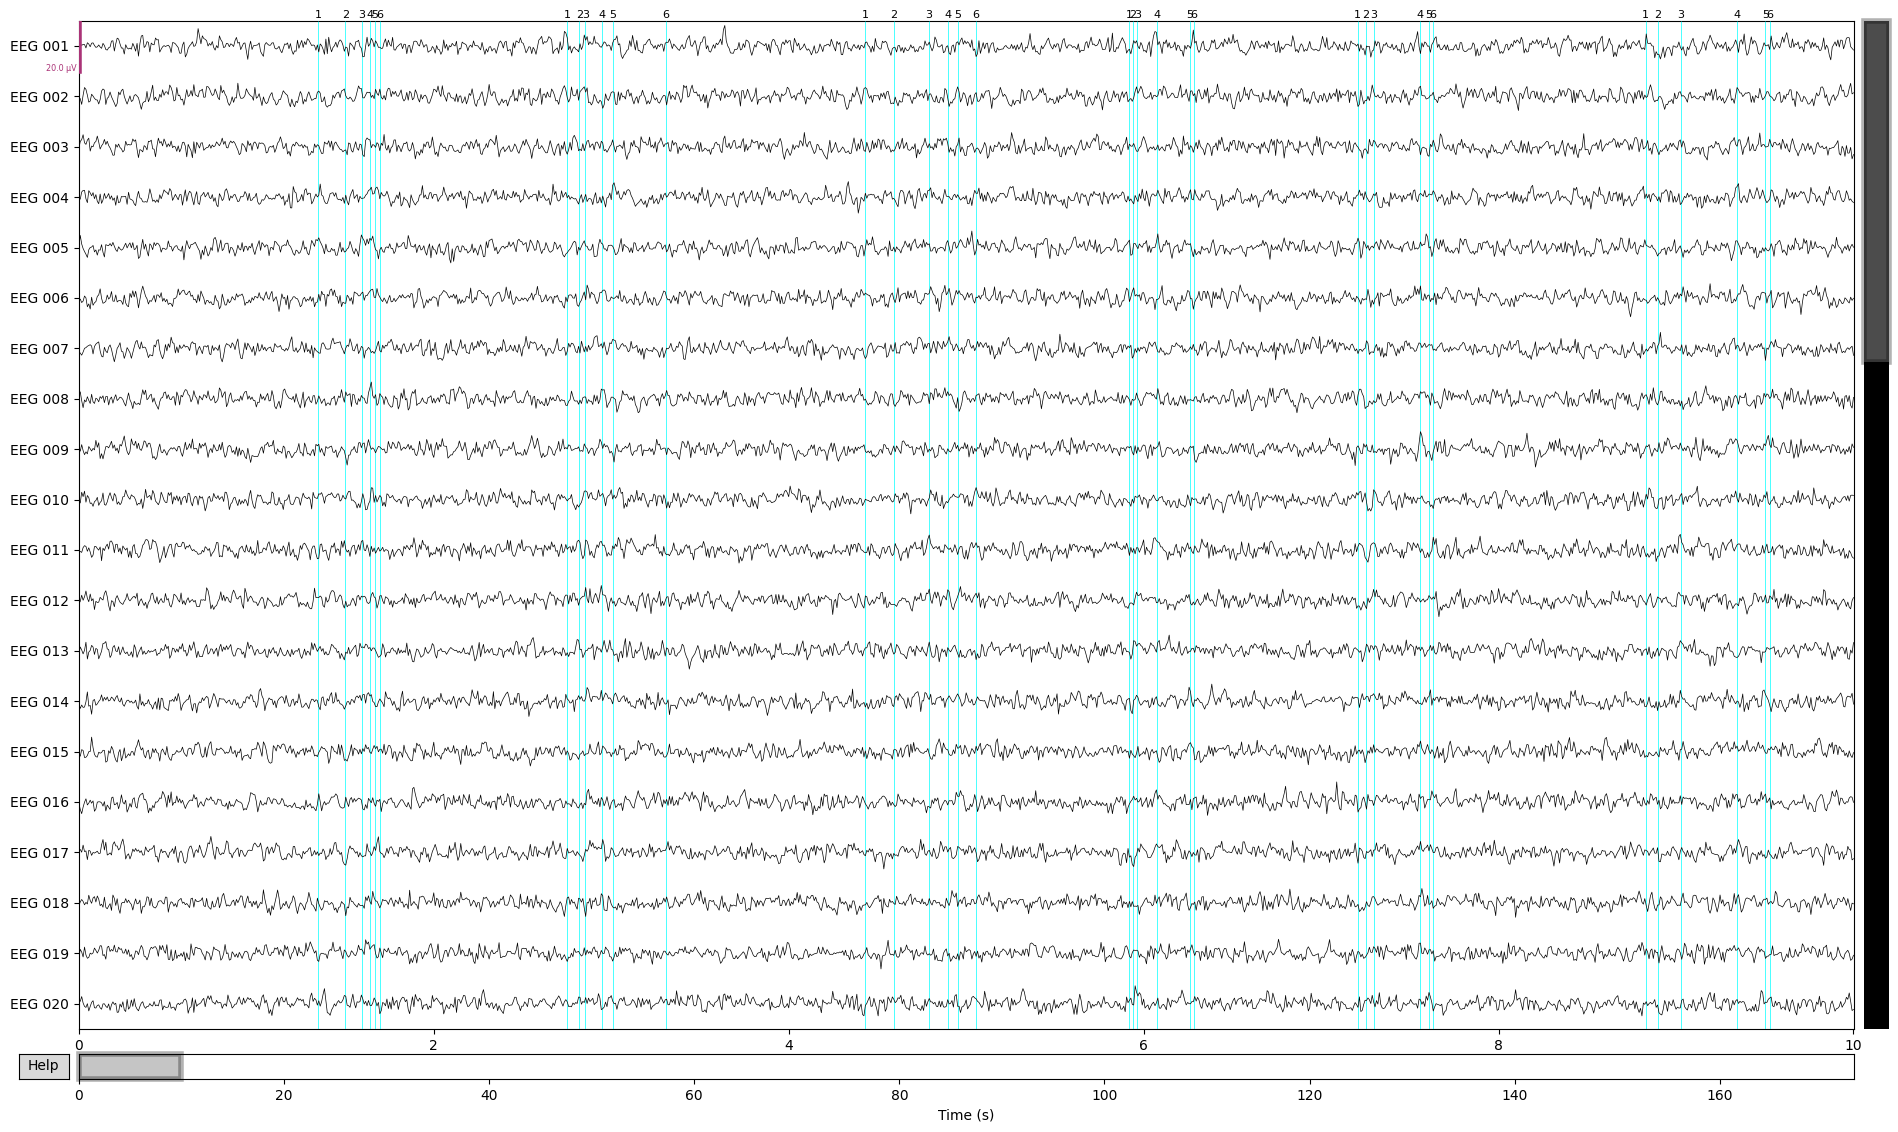

In [10]:
#Recovering the events to epoch the data (in the number of trials defined above)
events = np.load(file[1])
#Visualising the raw simulated EEG data
import mne
raw = mne.io.read_raw_fif(file[0], preload=False, verbose=False)
raw.pick_types(eeg=True).plot(scalings=dict(eeg=1e-5), events=events, block=True);


This looks close to actual data, we'll now illustrate how to read this data and prepare it for HMP analysis. The following code will read the raw data, epoch it from stimulus to response, and prepare it for HMP analysis.

### 2.1 Reading the data

First we have to declare what trigger to epoch on

In [11]:
stimulus_id = {'stimulus/dummy':1}#trigger 1 = stimulus, in real data this could be several e.g. {'stimulus/left': 1, 'stimulus/right':2} if you have several conditions for exmple

Then what trigger(s) define the response

In [12]:
resp_id = {'response/dummy':6} # trigger 6 = response, in real data this could again be multiple e.g. {'response/left': 6, 'response/right':7}

** Note** when using the following code, the triggers in stimulus_id and response_id are expected to follow the convention `'stimulus/condition_name': trigger_number` and `'response/condition_name': trigger_number`. This is the convention used in the MNE-Python library, which is also used by HMP.

Next we can directly use the ```file``` list and feed it to the ```hmp.io.read_mne_data``` but first you have to decide on a number of parameters regarding EEG processing, see the following helper of the function

In [13]:
import hmp
hmp.io.read_mne_data?

Signature:
hmp.io.read_mne_data(
    pfiles: str | list,
    event_id: dict | None = None,
    resp_id: dict | None = None,
    data_format: str = 'raw',
    sfreq: float | None = None,
    subj_name: list | None = None,
    metadata: list | None = None,
    events_provided: numpy.ndarray | None = None,
    rt_col: str = 'rt',
    rts: numpy.ndarray | None = None,
    verbose: bool = True,
    tmin: float = -0.2,
    tmax: float = 5,
    offset_after_resp: float = 0,
    high_pass: float | None = None,
    low_pass: float | None = None,
    pick_channels: str | list = 'eeg',
    baseline: tuple = (None, 0),
    upper_limit_rt: float = inf,
    lower_limit_rt: float = 0,
    reject_threshold: float | None = None,
    scale: float = 1,
    reference: str | None = None,
    ignore_rt: bool = False,
    bids_parameters: dict = {},
) -> xarray.core.dataset.Dataset
Docstring:
Read EEG/MEG data format (.fif or .bdf) using MNE's integrated function.

Notes
-----
- Only EEG or MEG data are sele

This is then an example call to the function based on previous _hmp_ applications

In [14]:
sfreq = 250 #at what sampling rate we want the data, downsampling to 250Hz just to show that we can use any SF
tmin, tmax = -.2, 2 #window size for the epochs, from 250ms before the stimulus up to 2 seconds after, data will be baseline corrected from tmin to 0
lower_limit_rt, upper_limit_rt = .2, 2 #lower and upper limit for the RTs, all values outside of this range are discarded, choose carefully

epoch_data = hmp.io.read_mne_data(file[0], 
                                  event_id=stimulus_id, # centering event
                                  resp_id=resp_id, # event defining the RT or duration
                                  data_format='raw',
                                  subj_name='S0', 
                                  tmin=tmin, tmax=tmax, 
                                  sfreq=sfreq,
                                  events_provided = events, # events structure, usually not needed as real data have a trigger channel from which this is inferred
                                  reject_threshold=1e-4,#Reject if more than 100microV between stimulus and response
                                 )

Processing participant /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/./dataset_raw.fif's raw eeg
Opening raw data file /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/./dataset_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60) active
    Range : 0 ... 86535 =      0.000 ...   173.070 secs
Ready.
Reading 0 ... 86535  =      0.000 ...   173.070 secs...
Downsampling to 250 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 81 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 80.65 Hz
- Upper transition bandwidth: 20.16 Hz (-6 dB cutoff frequency: 90.73 Hz)
- Filter length: 83 samples (0.166 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Creating epochs based on following event ID :[1 2 3 4 5 6]
Adding metadata with 2 columns
100 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 100 events and 1101 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 1.996 seconds
100 RTs kept of 100 clean epochs
0 trials rejected based on threshold of 0.0001
100 trials were retained for participant /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/./dataset_raw.fif
End sampling frequency is 250 Hz


This is then the data ready to be used with hmp instances

### 2.2 Working with sensor location

In this case as in the first example with epoched data, we can simply call the info object of one of the file to use the positions of the electrodes (note that this time the positions are recorded and not assumed).

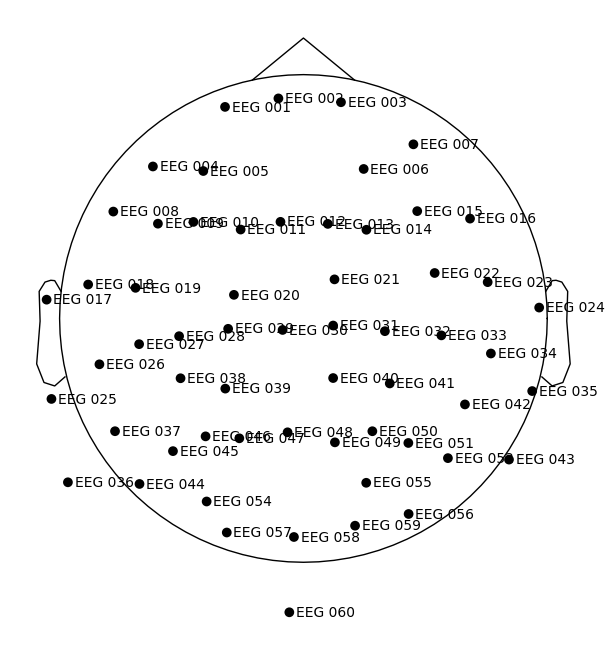

In [15]:
epoch = mne.io.read_raw(file[0])
epoch.plot_sensors(show_names=True);

In [16]:
# See the two next tutorials for more details on how to fit an HMP model and how to visualize the results.
preprocessed = hmp.preprocessing.Standard(epoch_data, n_comp=6)
pattern = hmp.patterns.HalfSine.create_expected(sfreq=epoch_data.sfreq)
trial_data = hmp.trialdata.TrialData.from_preprocessed(preprocessed=preprocessed, pattern=pattern.template)
model = hmp.models.EventModel(pattern, n_events=4)
_, estimates = model.fit_transform(trial_data)

/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/preprocessing.py:165: UserWarning: Data will be modified inplace, re-read the data or use copy=True if multiplecalls to this function
  warn(


Estimating 4 events model with 1 starting point(s)


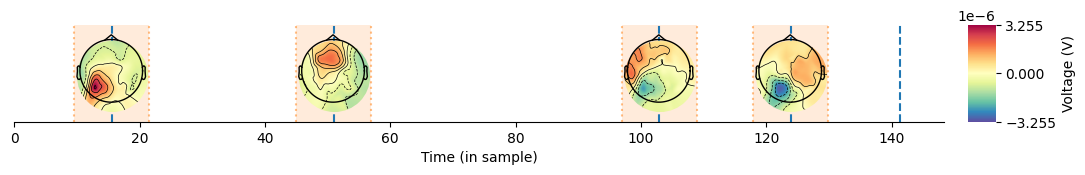

In [17]:
from mne.io import read_info
info = read_info(file[0], verbose=False)
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info)

## 3. Data already epoched from stimulus to response

In case you prefer to do your own stimulus-response epoching of your data, you can use the output to build an HMP data object as well.

In this case, you will create an HMP object for each subject, concatenate these in a list, and finally concatenate as xarray. Each subject matrix need to have shape ```epochs X channels X samples```, where non-existing datapoints (i.e. after the response) have the value NaN.

Assuming that the data were stored for each subject in a .fif file, this the required code:

```python
import numpy as np
import mne
import hmp
import xarray as xr

#subjects
subs = np.array(['77032','77038','77044'])

#list containing subject specific HMP objects
epoch_data = []

#for each subject:
for subj in subs:
    
    #load data
    #note that these data were preprocessed such that epochs._data has samples set to NaN after the response
    epochs = mne.read_epochs('sample_data/eeg_stim-resp-epoched/epochs_stim-to-resp-' + subj + '_epo.fif', preload=True, verbose=False)
 
    #make into hmp format and append to epoch_data
    epoch_data.append(hmp.utils.hmp_data_format(epochs.get_data(), epochs.info['sfreq'], None, channels = epochs.ch_names, metadata = epochs.metadata)) 

#concatenate into xarray
epoch_data = xr.concat(epoch_data, dim = xr.DataArray(subs, dims='participant'), fill_value={'event':'', 'data':np.nan})

#save
epoch_data.to_netcdf('sample_data/eeg_stim-resp-epoched/epoched_for_hmp.nc')
```


##  4. Reading BIDS data

Given the developments of the BIDS data structure, HMP comes with a function to read BIDS data and convert it to the HMP format. The BIDS format is particularly appropriate given that events are typically clearly defined along the E/MEG recordings, allowing for an easy reconstruction of the conditions for each trial. Check out the different tutorials in MATLAB or python on how to turn your data into BIDS.

Here below we illustrate how to prepare BIDS data from the ERP-core dataset transformed to BIDS (see https://osf.io/3zk6n). First we need to install the `mne_bids` package if not already installed. You can do this via pip:
`pip install mne_bids`
Then we download the data (1.8 GB!)

In [18]:
import mne_bids
from mne_bids import BIDSPath, read_raw_bids
import shutil
import platform

# ERP CORE BIDS dataset
# We'll use mne_bids to download and organize the first 5 participants' data

import os
import requests
from zipfile import ZipFile

# Download the ERP CORE P3 dataset (if not already present)

erp_core_url = "https://osf.io/download/3zk6n/"
zip_path = "sample_data/ERP_CORE_P3.zip"
extract_dir = "sample_data/"

if not os.path.exists(zip_path):
    print("Downloading ERP CORE dataset...")
    r = requests.get(erp_core_url, stream=True)
    with open(zip_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
print("Extracting ERP CORE dataset...")
with ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)



Extracting ERP CORE dataset...


And we read the data as in section 2 except that we specify the BIDS parameters to read the data from the BIDS dataset. Note that this requires the BIDS dataset to be structured correctly, with the events and metadata stored in the appropriate files.

In [19]:
import hmp

sfreq = 250 #at what sampling rate we want the data, downsampling to 250Hz just to show that we can use any SF
tmin, tmax = -.2, 2 #window size for the epochs, from 250ms before the stimulus up to 2 seconds after, data will be baseline corrected from tmin to 0
lower_limit_rt, upper_limit_rt = .2, 2 #lower and upper limit for the RTs, all values outside of this range are discarded, choose carefully

epoch_data = hmp.io.read_mne_data([], 
                                  data_format='bids',
                                  tmin=tmin, tmax=tmax, 
                                  sfreq=sfreq,
                                  bids_parameters={
                                      'bids_root': 'sample_data/ERP_CORE',
                                      'task': 'P3',
                                      'datatype': 'eeg',
                                      'session': 'P3'
                                  },
                                  reject_threshold=1e-4,#Reject if more than 100microV between stimulus and response
                                  reference='average',# VERY IMPORTANT, use the average as reference, other type of reference (except REST) can give weird topographies
                                  verbose=False
                                  )

Processing participant sub-018's bids eeg


/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:345: RuntimeWarning: Data file name in EEG.data (sub-018_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-018_ses-P3_task-P3_eeg.fdt).
  data = mne_bids.read_raw_bids(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:345: RuntimeWarning: Unable to map the following column(s) to to MNE:
handedness: right
  data = mne_bids.read_raw_bids(


Downsampling to 250 Hz


/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target A, trial stimulus A (event id 11)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target B, trial stimulus A (event id 21)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target A, trial stimulus B (event id 12)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target B, trial stimulus B (event id 22)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target A, trial stimulus C (event id 13)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events fou

36 trials rejected based on threshold of 0.0001
164 trials were retained for participant sub-018
Processing participant sub-019's bids eeg
Downsampling to 250 Hz


/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target A, trial stimulus A (event id 11)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target B, trial stimulus A (event id 21)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target A, trial stimulus B (event id 12)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target B, trial stimulus B (event id 22)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target A, trial stimulus C (event id 13)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events fou

0 trials rejected based on threshold of 0.0001
200 trials were retained for participant sub-019
Processing participant sub-015's bids eeg


/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:345: RuntimeWarning: Unable to map the following column(s) to to MNE:
handedness: right
  data = mne_bids.read_raw_bids(


Downsampling to 250 Hz


/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target A, trial stimulus A (event id 11)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target B, trial stimulus A (event id 21)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target A, trial stimulus B (event id 12)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target B, trial stimulus B (event id 22)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target A, trial stimulus C (event id 13)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events fou

2 trials rejected based on threshold of 0.0001
198 trials were retained for participant sub-015
Processing participant sub-017's bids eeg
Downsampling to 250 Hz


/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target A, trial stimulus A (event id 11)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target B, trial stimulus A (event id 21)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target A, trial stimulus B (event id 12)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target B, trial stimulus B (event id 22)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target A, trial stimulus C (event id 13)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events fou

33 trials rejected based on threshold of 0.0001
167 trials were retained for participant sub-017
Processing participant sub-016's bids eeg
Downsampling to 250 Hz
5 trials rejected based on threshold of 0.0001
195 trials were retained for participant sub-016


/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target A, trial stimulus A (event id 11)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target B, trial stimulus A (event id 21)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target A, trial stimulus B (event id 12)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target B, trial stimulus B (event id 22)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events found for stimulus/block target A, trial stimulus C (event id 13)
  epochs = mne.Epochs(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/io.py:422: RuntimeWarning: No matching events fou

And we can use the data as in the other cases

In [20]:
# See the two next tutorials for more details on how to fit an HMP model and how to visualize the results.
preprocessed = hmp.preprocessing.Standard(epoch_data, n_comp=10)
pattern = hmp.patterns.HalfSine.create_expected(sfreq=epoch_data.sfreq)
trial_data = hmp.trialdata.TrialData.from_preprocessed(preprocessed=preprocessed, pattern=pattern.template)
model = hmp.models.EventModel(pattern, n_events=4)
_, estimates = model.fit_transform(trial_data)

/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/preprocessing.py:165: UserWarning: Data will be modified inplace, re-read the data or use copy=True if multiplecalls to this function
  warn(
/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/preprocessing.py:347: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Estimating 4 events model with 1 starting point(s)


For the electrode position we can build a montage based on the names of the electrodes in the dataset

/tmp/ipykernel_46722/1064243124.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info = info.set_montage(montage, verbose=False)


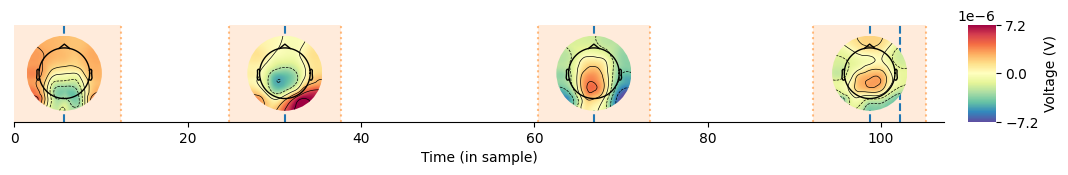

In [21]:
# Rename FP1 and FP2 channels to Fp1 and Fp2
epoch_data = epoch_data.assign_coords(
    channel=[
        ch.replace("FP1", "Fp1").replace("FP2", "Fp2") if ch in ["FP1", "FP2"] else ch
        for ch in epoch_data.channel.values
    ]
)

montage = mne.channels.make_standard_montage('standard_1020')
# Keep only channels in the montage that are in epoch_data.channel
keep_chs = [ch for ch in montage.ch_names if ch in list(epoch_data.channel.values)]
# Create a new montage with only the desired channels
montage = mne.channels.make_dig_montage(
    {ch: montage.get_positions()['ch_pos'][ch] for ch in keep_chs},
    coord_frame=montage.get_positions()['coord_frame']
)

info = mne.create_info(list(epoch_data.channel.values), sfreq, ch_types='eeg')
info = info.set_montage(montage, verbose=False)
hmp.visu.plot_topo_timecourse(epoch_data, estimates,info)

Note that in this case the data was not preprocessed so still contains large artifacts (e.g. blinks).

## 4. Reading alternative data formats

If none of these case are suitable to you then it'll require quite a lot of work as we cannot account for the multiple ways EEG data can be acquired and processed. To avoid such hassle we advise to either re-read the data in MNE and use the functions in 1. or convert the dataset to BIDS and use the dunctions in 4. If none of these would be suitable, we provide here an example that we made for the P3 task of the [ERP CORE dataset ](https://erpinfo.org/erp-core). This code reads the data from the P3 task, processes it, and saves it in an MNE format that can then be used as in 1.1. The code uses read the EEG epochs with MNE, sets channel types, applies an average reference to the EEG data and re-shape the metadata. It also translates event codes into a more readable format and saves the processed epochs in a new file.

```python
import os
import re
import mne
import numpy
import pandas as pd
from concurrent.futures import ProcessPoolExecutor

# Define the base path where the numbered folders are located
base_path = 'P3 All Data and Scripts/'
base_path = os.path.expanduser(base_path)

# Define the channel types to be set
channel_types = {
    'HEOG_left': 'eog',
    'HEOG_right': 'eog',
    'VEOG_lower': 'eog',
    '(corr) HEOG': 'eog',
    '(corr) VEOG': 'eog',
    '(uncorr) HEOG': 'eog',
    '(uncorr) VEOG': 'eog'
}

mapping_scheme = {
    11: ['A', 1, 'A', 1],
    21: ['B', 2, 'A', 1],
    31: ['C', 3, 'A', 1],
    41: ['D', 4, 'A', 1],
    51: ['E', 5, 'A', 1],
    12: ['A', 1, 'B', 2],
    22: ['B', 2, 'B', 2],
    32: ['C', 3, 'B', 2],
    42: ['D', 4, 'B', 2],
    52: ['E', 5, 'B', 2],
    13: ['A', 1, 'C', 3],
    23: ['B', 2, 'C', 3],
    33: ['C', 3, 'C', 3],
    43: ['D', 4, 'C', 3],
    53: ['E', 5, 'C', 3],
    14: ['A', 1, 'D', 4],
    24: ['B', 2, 'D', 4],
    34: ['C', 3, 'D', 4],
    44: ['D', 4, 'D', 4],
    54: ['E', 5, 'D', 4],
    15: ['A', 1, 'E', 5],
    25: ['B', 2, 'E', 5],
    35: ['C', 3, 'E', 5],
    45: ['D', 4, 'E', 5],
    55: ['E', 5, 'E', 5]
}


# Function to translate ecode using the mapping scheme
def translate_ecode(ecode, mapping_scheme):
    return mapping_scheme.get(ecode, [None] * 6)


# Iterate over the numbered folders
def process_folder(folder):
        folder_path = os.path.join(base_path, folder)
        
        # Read the EEG epochs
        epochs_path = os.path.join(folder_path, f'{folder}_P3_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set')
        epochs = mne.read_epochs_eeglab(epochs_path)
        
        # Set the channel types
        epochs.set_channel_types(channel_types)
        
        # Pick only EEG channels
        epochs = epochs.pick_types(eeg=True)
        
        # Read the event list file (if needed)
        event_list_path = os.path.join(folder_path, f'{folder}_P3_Eventlist_RTs.txt')
        with open(event_list_path, 'r') as file:
            lines = file.readlines()

        # Find the line where the actual data starts
        data_start = 0
        for i, line in enumerate(lines):
            if line.startswith('# item'):
                data_start = i + 2  # data starts two lines after the header line
                break
        
        # Process the data lines into a list of dictionaries
        data = []
        for line in lines[data_start:]:
            if not line.strip():  # Skip empty lines
                continue
            # Split line by whitespace
            split_line = line.split()
            # Combine all parts after the 10th element (index 9) into one field
            combined_last_field = ' '.join(split_line[10:])
            # Extract digits from the brackets
            digits_in_brackets = re.findall(r'\d+', combined_last_field)
            # Append the first 10 elements and the list of digits
            data.append({
                'item': split_line[0],
                'bepoch': split_line[1],
                'ecode': split_line[2],
                'label': split_line[3],
                'onset': split_line[4],
                'diff': split_line[5],
                'dura': split_line[6],
                'b_flags': split_line[7],
                'a_flags': split_line[8],
                'enable': split_line[9],
                'bin': digits_in_brackets
            })
        # MNE read trigger description
        mapping_dict = epochs.event_id
        # Create the DataFrame
        df = pd.DataFrame(data)
        df['rt'] = df['diff'].shift(-1)
        
        metadata = df
        metadata.bepoch = metadata.bepoch.astype(int)
        metadata.ecode = metadata.ecode.astype(int)
        metadata['rt'] = metadata['rt'].astype(float)
        
        arr = epochs.events.copy()
        # Invert keys and values of mapping_dict, keeping only the three-digit code in parentheses
        inverted_mapping = {v: k.split('(')[1].split(')')[0] for k, v in mapping_dict.items() if '(' in k}
        
        # Replace last column using inverted mapping dictionary
        arr[:, -1] = [int(inverted_mapping.get(row[2])) for row in arr]
        
        # Find indices where metadata_ecode matches arr_last_column
        indices = []
        filtered_metadata = metadata.copy()
        i = 0
        for value in arr[:,-1]:
            while i < len(metadata.ecode) and metadata.ecode.values[i] != value:
                i += 1
            indices.append(i)
            i += 1
        
        assert (arr[:,-1] ==  metadata.ecode.values[indices]).all()

        # Create a DataFrame from metadata_ecode and translate using the mapping scheme
        translated_columns = ['target', 'num1', 'stimulus', 'num2',  '_','__']
        metadata[translated_columns] = metadata['ecode'].apply(lambda x: pd.Series(translate_ecode(x, mapping_scheme)))
        metadata['Trial type'] = (metadata['target'] == metadata['stimulus']).astype(str).replace({'True': 'Rare', 'False': 'Frequent'})
        epochs.metadata = metadata.iloc[indices]
        
        # Remove epoch discarded during AR
        filtered_metadata = epochs.metadata[epochs.metadata['bin'].apply(lambda x: len(x) > 1)]
        epochs_clean = epochs[filtered_metadata.index]
        epochs_clean.set_eeg_reference('average')
        epochs_clean.apply_baseline()
        epochs_clean.save(f'P3/{folder}_reref_epo.fif', overwrite=True)
        print(f'Saved {folder}')

# Get the list of folders to process
folders = [folder for folder in os.listdir(base_path) if folder.isdigit()]

# Use ProcessPoolExecutor to parallelize the processing
with ProcessPoolExecutor() as executor:
    executor.map(process_folder, folders)
```
